## Is it a bird?

Fastai学习笔记
2025.5.20

In [95]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

这段代码用于检查网络的可用性

In [96]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

- -U upgrade
- -q 更少的信息
- 因为notebook在云端运行, 每次打开一个新的notebook都需要```!pip install -Uqq fastai 'dockduckgo_search>=6.2'```来获取最新的fastai库

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

2015年的一个漫画, 用计算机分辨是否是一只鸟是**几乎不可能的**, 但在现在, 有了深度学习之后, 事情变得简单

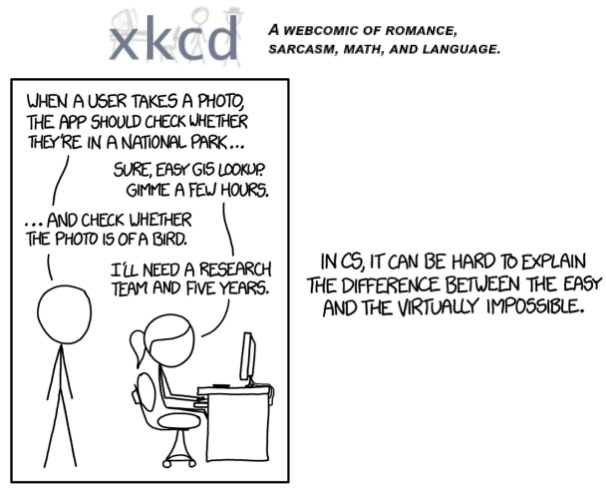

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

用计算机去实现一个是否是鸟的判断
1. 搜索鸟的图片
2. 搜索非鸟的图片, 这里用森林
3. Fine-tune(微调) 前人调好的神经网络来识别我们的鸟和非鸟
4. 用我们调好的模型来判断是否是鸟

## Step 1: Download images of birds and non-birds 下载鸟和非鸟的图片

In [97]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

定义一个从ddgs搜索图片的函数: 根据关键词和最大搜索量, 在ddgs上搜索图片

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

搜索一个鸟的图片, 返回图片的url

In [98]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
bird_urls = search_images('bird photos', max_images=1)
bird_url = bird_urls[0]

...and then download a URL and take a look at it:

尝试下载这个url, 当然是下载到运行这个notebook的服务器上

In [99]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(bird_url, dest, show_progress=True) ##库函数中提供的下载url链接的方法, (下载的url地址, 保存路径, 是否展示下载进度条)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256) ##展示缩略图256*256

OSError: [Errno 30] Read-only file system: 'bird.jpg'

In [ ]:
!pwd
!ls

Now let's do the same with "forest photos":

同样下载森林的图片

In [ ]:
hamster_url = search_images('hamster photos', max_images=100)[1]
download_url(hamster_url, 'hamster.jpg', show_progress=True)
Image.open('hamster.jpg').to_thumb(256,256)

搜索和下载过程可能会失败, 失败的话多试几次

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

上述结果表明, 我们确实能搜索并下载鸟和森林的图片, 现在我们需要搜索并下载一组图片, 将他们按照鸟和森林保存在不同的文件夹
这个文件夹的名称之后将作为标签

In [ ]:
searches = 'hamster','bird'
path = Path('hamster_or_not')

for o in searches:
    dest = (path/o) ## bird_or_not/bird 和 bird_or_not/forest
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo')) ## 注意区别之前使用的download_url()函数, 这里一次下载了多个图片
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

因为图片数量较多, 下载消耗时间较多

我们之后训练模型使用的图片如果太大, 打开图片消耗时间会很多, 这里用resize_images()调整图片大小

## Step 2: Train our model 训练模型

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

下载过程可能会遇到下载失败的情况, 我们先要移除这些下载失败的图片

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

训练模型首先需要DataLoaders(数据加载器) 包括
1. 训练集
2. 验证集

fastai库提供了一个DataBlock类

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), ## 指定模型输入是图片, 输出是分类
    get_items=get_image_files, ## 获取模型输入的方法, 这里传入get_image_files()
    splitter=RandomSplitter(valid_pct=0.2, seed=42), ## 将数据随机分为80%训练集和20%验证集
    get_y=parent_label, ## 指定数据的标签, 这里就是文件的父目录
    item_tfms=[Resize(192, method='squish')] ## 在训练前, 调整图像尺寸, 这里用squish(压缩). 对应的还有crop(裁切)
).dataloaders(path, bs=32)

dls.show_batch(max_n=6) ## 从数据加载器中展示6张图片

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

准备好训练模型```resnet18```

fastai库提供了一个fine_tune()微调模型的接口

In [ ]:
hamster_learn = vision_learner(dls, resnet18, metrics=error_rate)
hamster_learn.fine_tune(3)

Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

模型微调
- 是在前人已经训练好的模型基础上进行
- 这里下载下来的```resnet18```是用于广泛被用来图像分类
- 微调会轻微改变函数的权重, 来让模型去学习识别我们指定的数据集

## Step 3: Use our model (and build your own!) 使用我们训练的模型

Let's see what our model thinks about that bird we downloaded at the start:

使用刚刚训练好的模型来尝试判断一下之前下载的图片是不是鸟

This is a: bird.
Probability it's a hamster: 0.0000


<Axes: >

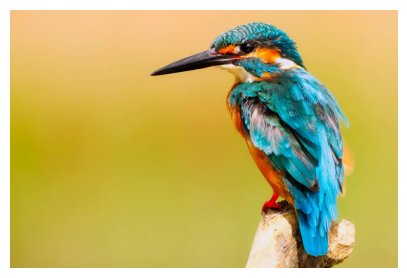

In [111]:
my_hamster_image= PILImage.create('bird.jpg')
is_hamster,_,probs = hamster_learn.predict(my_hamster_image)
print(f"This is a: {is_hamster}.")
print(f"Probability it's a hamster: {probs[1]:.4f}")
my_hamster_image.show()

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

有了深度学习, 建立一个图像识别的模型如此简单

而且不止图像识别领域, 深度学习还广泛用于其他很多领域

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

In [ ]:
自己调整数据接实现仓鼠分辨器

很明显如果数据集只有鸟和仓鼠的图片, 很难区分开长得像仓鼠但不是仓鼠的图片

现在的模型只适用于二元分类